# Start

In [2]:
# old name Modulation_AllGenes_Shift
import os
import random
import time
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio.Seq import MutableSeq
from Bio.Seq import Seq
from Bio.Data.CodonTable import unambiguous_dna_by_id
from Bio.SeqUtils import seq3
from scipy.stats import spearmanr
from scipy.stats import pearsonr    
from tqdm.notebook import tqdm

MUT_SPEC_DATA = pd.read_csv(r'C:\Work\Lab\pr-29-trna-or-mutagenesis\raw\VertebratePolymorphisms.MutSpecData.OnlyFourFoldDegAllGenes.csv', sep=' ').copy()
AA = pd.read_csv(r'C:\Work\Lab\Practice\AminoAcidsUsageAllGenes.csv', sep='\t').copy()
CU = pd.read_csv(r'C:\Work\Lab\pr-29-trna-or-mutagenesis\raw\CodonUsage.csv', sep='\t').copy()
CU_genes = pd.read_csv(r'C:\Work\Lab\pr-29-trna-or-mutagenesis\raw\AllGenesCodonUsage.csv', sep='\t').copy()
CU_genes = CU_genes[CU_genes.Gene!='ND6']
observed_frequency_df = pd.read_csv(r'C:\Work\Lab\Practice\CodonFrequencyAllGenes.csv', sep='\t').copy()

CODON_TABLE = 2     # Вариации генетического кода с NCBI:
                    # 1: Standard   2: Vertebrate Mitochondrial 3: Yeast Mitochondrial
                    # 4: Mold Mitochondrial; Protozoan Mitochondrial; Coelenterate Mitochondrial; Mycoplasma; Spiroplasma
                    # 5: Invertebrate Mitochondrial     6: Ciliate Nuclear; Dasycladacean Nuclear; Hexamita Nuclear
                    # 9: Echinoderm Mitochondrial; Flatworm Mitochondrial   10: Euplotid Nuclear
                    # 11: Bacterial, Archaeal and Plant Plastid     12: Alternative Yeast Nuclear
                    # 13: Ascidian Mitochondrial    14: Alternative Flatworm Mitochondrial
                    # 16: Chlorophycean Mitochondrial   21: Trematode Mitochondrial
                    # 22: Scenedesmus obliquus Mitochondrial Code   23: Thraustochytrium mitochondrial code
                    # 24: Pterobranchia Mitochondrial   25: Candidate Division SR1; Gracilibacteria
                    # 26: Pachysolen tannophilus Nuclear Code   27: Karyorelict Nuclear     28: Condylostoma Nuclear
                    # 29: Mesodinium Nuclear    30: Peritrich Nuclear  31: Blastocrithidia Nuclear

ALL_CODONS = ['AAA', 'AAC', 'AAG', 'AAT', 'ACA', 'ACC', 'ACG', 'ACT', 'AGA', 'AGC', 'AGG', 'AGT', 'ATA', 'ATC',
            'ATG', 'ATT', 'CAA', 'CAC', 'CAG', 'CAT', 'CCA', 'CCC', 'CCG', 'CCT', 'CGA', 'CGC', 'CGG', 'CGT',
            'CTA', 'CTC', 'CTG', 'CTT', 'GAA', 'GAC', 'GAG', 'GAT', 'GCA', 'GCC', 'GCG', 'GCT', 'GGA', 'GGC',
            'GGG', 'GGT', 'GTA', 'GTC', 'GTG', 'GTT', 'TAA', 'TAC', 'TAG', 'TAT', 'TCA', 'TCC', 'TCG', 'TCT',
            'TGA', 'TGC', 'TGG', 'TGT', 'TTA', 'TTC', 'TTG', 'TTT']    # Список всех 64 кодонов

# list of species with stop codons in their codon usage
err_list = ['Acheilognathus_macropterus', 'Acheilognathus_yamatsutae', 'Acipenser_gueldenstaedtii', 'Ara_militaris', 'Brotogeris_cyanoptera', 'Capra_sibirica', 'Cardinalis_cardinalis', 'Chlorocebus_aethiops', 'Chlorocebus_sabaeus', 'Cobitis_sinensis', 'Conolophus_subcristatus', 'Crocidura_russula', 'Crocodylus_moreletii', 'Dasyurus_hallucatus', 'Desmognathus_fuscus', 'Eulemur_rubriventer', 'Eurystomus_orientalis', 'Falco_sparverius', 'Fringilla_coelebs', 'Gyrinophilus_porphyriticus', 'Oncorhynchus_keta', 'Scombrops_gilberti']
species_list = os.listdir('C:\Work\Lab\Practice\Results_AllGenes_shift')
species_list = sorted(list(set(species_list)-set(err_list)))

TOTAL_MUTATIONS = 150*150       # ~22k достаточно для насыщения изменения кодонов
MUTATIONS_PER_GEN = 100
TOTAL_GENERATIONS = TOTAL_MUTATIONS // MUTATIONS_PER_GEN     # Количество поколений



# result_folder = 'C:\Work\Lab\pr-29-trna-or-mutagenesis\local data\Simulation results(sel)'

c:\Soft\Python\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## AA_dict

In [1]:
# Создает словарь {Аминокислота : [кодоны]} на основе таблиц кодонов с NCBI

def aa_dict_creator(letters_3: bool = True , CODON_TABLE=2):
    aa_dict = {}
    stop_codons = {codon:'_' for codon in unambiguous_dna_by_id[CODON_TABLE].stop_codons}
    c_aa_dic = unambiguous_dna_by_id[CODON_TABLE].forward_table | stop_codons
    for (codon, aa) in c_aa_dic.items():
        if letters_3:
            aa = seq3(aa)

        if codon[:2] == 'CT':
            aa = 'Leu1' if letters_3==True else 'L1'
        elif codon == 'TTG' or codon == 'TTA':
            aa = 'Leu2' if letters_3==True else 'L2'
        if codon[:2] == 'TC':
            aa = 'Ser2' if letters_3==True else 'S1'
        elif codon == 'AGT' or codon == 'AGC':
            aa = 'Ser1' if letters_3==True else 'S2'

        if aa not in aa_dict:
            aa_dict[aa] = []

        aa_dict[aa].append(codon)
    return aa_dict

aa_dict = aa_dict_creator(True)
aa_dict_seq1 = aa_dict_creator(False)

# Change tRNA sequencies to DNA ones
def rev_compl_dict(dic):
    for aa, ac in dic.items():
        dic[aa] = str(Seq(ac).back_transcribe().reverse_complement())
    return dic

# Dicts of cognate codons
ac_codon_dict_full = {
    'Phe':'GAA', 'Leu2':'TAA', 'Ser2':'TGA', 'Tyr':'GTA', 'Cys':'GCA', 'Trp':'UCA', 'Leu1':'UAG',
    'Pro':'UGG', 'His':'GUG', 'Gln':'UUG', 'Arg':'UCG', 'Ile':'GAU', 'Met':'CAU', 'Thr':'UGU', 
    'Asn':'GUU','Ser1':'GCU', 'Val':'UAC', 'Ala':'UGC', 'Asp':'GUC', 'Glu':'UUC', 'Gly':'UCC', 'Lys':'UUU'}
ac_codon_dict_full = rev_compl_dict(ac_codon_dict_full)
# ac_codon_dict = {
#     'Phe':'GAA', 'Ser':'TGA', 'Tyr':'GTA', 'Cys':'GCA', 'Trp':'UCA', 'Leu':'UAG',
#     'Pro':'UGG', 'His':'GUG', 'Gln':'UUG', 'Arg':'UCG', 'Ile':'GAU', 'Met':'CAU', 'Thr':'UGU', 
#     'Asn':'GUU', 'Val':'UAC', 'Ala':'UGC', 'Asp':'GUC', 'Glu':'UUC', 'Gly':'UCC', 'Lys':'UUU'}
# ac_codon_dict = rev_compl_dict(ac_codon_dict)

mutations = ['A_T', 'A_G', 'A_C', 'T_A', 'T_G', 'T_C', 'G_A', 'G_T', 'G_C', 'C_A', 'C_T', 'C_G']    # Список однонуклеотидных замен

codon_dict = {}
for aa in aa_dict:
    for codon in aa_dict[aa]:
        codon_dict[codon] = aa

NameError: name 'unambiguous_dna_by_id' is not defined

In [14]:
for aa in ac_codon_dict_full:
    print(f'{aa_dict[aa]}, anticodon: {ac_codon_dict_full[aa]}')

['TTT', 'TTC'], anticodon: TTC
['TTA', 'TTG'], anticodon: TTA
['TCT', 'TCC', 'TCA', 'TCG'], anticodon: TCA
['TAT', 'TAC'], anticodon: TAC
['TGT', 'TGC'], anticodon: TGC
['TGA', 'TGG'], anticodon: TGA
['CTT', 'CTC', 'CTA', 'CTG'], anticodon: CTA
['CCT', 'CCC', 'CCA', 'CCG'], anticodon: CCA
['CAT', 'CAC'], anticodon: CAC
['CAA', 'CAG'], anticodon: CAA
['CGT', 'CGC', 'CGA', 'CGG'], anticodon: CGA
['ATT', 'ATC'], anticodon: ATC
['ATA', 'ATG'], anticodon: ATG
['ACT', 'ACC', 'ACA', 'ACG'], anticodon: ACA
['AAT', 'AAC'], anticodon: AAC
['AGT', 'AGC'], anticodon: AGC
['GTT', 'GTC', 'GTA', 'GTG'], anticodon: GTA
['GCT', 'GCC', 'GCA', 'GCG'], anticodon: GCA
['GAT', 'GAC'], anticodon: GAC
['GAA', 'GAG'], anticodon: GAA
['GGT', 'GGC', 'GGA', 'GGG'], anticodon: GGA
['AAA', 'AAG'], anticodon: AAA


# No sel simulation

In [ ]:
result_folder = 'C:\Work\Lab\pr-29-trna-or-mutagenesis\local data\Simulation results(no sel & no mut_id)'

for species in species_list[:1]: # Цикл по списку видов
    probability = 0
    mutspec = list(MUT_SPEC_DATA[MUT_SPEC_DATA.Species == species].iloc[0].values[1:])  # Вытаскивает мутспек для текущего вида
    mutspec_stack = []

    for i in range(len(mutspec)):   # Представляет мутспек в виде отрезка от 0 до 1, чтобы работала рулетка
        mutspec_stack.append(probability)
        probability += float(mutspec[i])


    for sample in tqdm(range(20)): # Количество генераций каждого вида(см. сколько папок уже есть в папке каждого вида)
        os.makedirs(f"{result_folder}/{species}/{sample}", exist_ok=True)  # Создает папку для результатов

        # Генератор генома на основе CodonUsage текущего вида
        DNA = []

        for aminoacid in AA.columns.values[:-1]:
            odds = [0]
            for i in range(len(aa_dict_seq3[aminoacid])):    # Создаем список вероятностей по вырождености аминокислоты
                odds.append(random.random() + odds[-1])
            for k in range(AA[AA.Species == species][aminoacid].values[0]):  # Цикл длиной кол-ву кодонов для аминокислоты
                odd = random.uniform(0, odds[-1])
                for q in range(len(aa_dict_seq3[aminoacid])):    # Для учета вырожденности АА
                    if odd < odds[q+1] and odd > odds[q]:
                        DNA.append(aa_dict_seq3[aminoacid][q])

        CodonUsage_list = []     # Создаем датафреймы для подсчета CodonUsage и
        Frequency_list = []
        observed_frequency = pd.read_csv(r'C:\Work\Lab\Practice\CodonFrequencyAllGenes.csv', sep='\t').copy()
        Frequency_list.append(list(observed_frequency[observed_frequency.Species == species].values[0][1:]))    # Записывает частоты кодонов из живого генома текущего вида

        mutations = ['A_T', 'A_G', 'A_C', 'T_A', 'T_G', 'T_C', 'G_A', 'G_T', 'G_C', 'C_A', 'C_T', 'C_G']
            # Список однонуклеотидных замен
        codon_mut_choice_time = 0
        for generation in range(TOTAL_GENERATIONS):
            errouneous_sp_counter = 0
            if generation % 1 == 0: # Регулирует раз в сколько поколений считать частоты кодонов
                codon_usage = Counter(DNA)      # Расчет CodonUsage
                CodonUsage_list.append([])
                if len(list(codon_usage)) < 64:                     # Проверка наличия всех 64 кодонов
                    for t in ALL_CODONS:                              # без нее возникали ошибки
                        if t not in list(codon_usage):              # если кодон исчезает приписываем ему ноль
                            codon_usage[t] = 0
                for codon in ALL_CODONS:     # Записывает CodonUsage
                    CodonUsage_list[generation].append(codon_usage[codon])
                frequency_values = []  # Список значений частот кодонов
                for e in range(64):
                    frequency_values.append(CodonUsage_list[generation][e] / len(DNA))   # Расчитывает частоту каждого кодона
                Frequency_list.append(frequency_values)  # Записывает в строку текущего поколения

                # Сохраняет значения

            # Мутагенез через список кодонов
            mut_counter = 0
            
            while mut_counter < MUTATIONS_PER_GEN:        # Цикл по всей ДНК # and generation < TOTAL_GENERATIONS-1
                codon_mut_choice_timer = time.time()

                codon_id = random.randint(0, len(DNA)-1)
                codon = MutableSeq(DNA[codon_id])   # Выбираем отдельный кодон
                mut_id = random.randint(0, 2)       # Выбираем нуклеотид из этого кодона
                # mut_id = 2
                mut_probability = random.uniform(0, mutspec_stack[-1])  # Задаем значение рулетки
                counter = 0
                while mut_probability >= mutspec_stack[counter + 1]:    # Смотрим на какою именно замену она выпала
                    counter += 1

                if codon[mut_id] == mutations[counter][0]:              # Сопоставляем нуклеотид замены из мутспека с
                    new_codon = MutableSeq(codon)                                   # выбранным нуклеотидом из кодона
                    codon = Seq(codon)
                    new_codon[mut_id] = mutations[counter][2]           # Подставляем нуклеотид в кодоне
                    codon_aa = seq3(codon.translate(table=CODON_TABLE))
                    new_codon_aa = seq3(new_codon.translate(table=CODON_TABLE))
                    
                    if new_codon_aa != codon_aa:
                        continue
        
                    # codon_WCF = True if codon == ac_codon_dict[codon_aa] else False
                    # new_codon_WCF = True if new_codon == ac_codon_dict[new_codon_aa] else False
                    
                    success = random.random()   # 'success' treshold is needed for possibility of positive selection
                                                # it's impossible to make a substitution more frequent without it
                    selection_multiplier = 0
                    
                    if success < (0.8+0.8*selection_multiplier):
                        DNA[codon_id] = str(new_codon)     # Проверка на синонимичность мутировавшего кодона
                        mut_counter += 1


        CodonUsage = pd.DataFrame(data=CodonUsage_list, columns=ALL_CODONS)
        Frequency = pd.DataFrame(data=Frequency_list, columns=ALL_CODONS)
        
        CodonUsage.to_csv(f'{result_folder}\{species}\{sample}\Codons.csv', sep='\t', index=False)
        Frequency.to_csv(f'{result_folder}\{species}\{sample}\Frequencies.csv', sep ='\t', index=False)
        
        # Расчет корреляций и p-value
        data = pd.read_csv(f'{result_folder}\{species}\{sample}\Frequencies.csv', sep='\t').copy()
        spearman = []
        pearson = []
        pv_s = []
        pv_p = []
        data1 = data.loc[0]
        for i in data.index.values[1:]:
            data2 = data.loc[i]
            corrp, p_p = pearsonr(data1, data2)
            corrs, p_s = spearmanr(data1, data2)
            spearman.append(corrs)
            pearson.append(corrp)
            pv_s.append(p_s)
            pv_p.append(p_p)
        spear_corr = pd.DataFrame({'spearman':spearman, 'pearson':pearson, 'pv_s':pv_s, 'pv_p':pv_p})
        spear_corr.to_csv(f'{result_folder}\{species}\{sample}\Spearman.csv', sep='\t', index=False)    # Расчет корреляций закончен



        # Расчет средних частот кодонов для ВСЕХ смодулированных образцов и корреляций
    samples_number = len(next(os.walk(f'{result_folder}\{species}'))[1])    # Количество смодулированных образцов
    # for i in next(os.walk(f'{result_folder}\{species}'))[1]:     
    #     # if i.isnumeric(): 
    #     samples_number += 1                   # os.walk выдает кортежи(path, dirnames, filenames)

    # Средние частоты
    FrequenciesMean = pd.DataFrame(0, index=range(TOTAL_GENERATIONS+1), columns=ALL_CODONS)


    for sample in range(samples_number):
        freq = pd.read_csv(f'{result_folder}\{species}\{sample}\Frequencies.csv', sep='\t').copy()
        FrequenciesMean += freq
    FrequenciesMean /= samples_number
    
    FrequenciesMean.to_csv(f'{result_folder}\{species}\FrequenciesMean.csv', sep='\t', index=False)

    # Корреляции
    spearman = []
    pearson = []
    pv_s = []
    pv_p = []
    data1 = FrequenciesMean.loc[0]
    for i in FrequenciesMean.index[1:]:
        data2 = FrequenciesMean.loc[i]
        corrp, p_p = pearsonr(data1, data2)
        pearson.append(corrp)
        pv_p.append(p_p)
        corrs, p_s = spearmanr(data1, data2)
        spearman.append(corrs)
        pv_s.append(p_s)
    
    spear_corr = pd.DataFrame({'spearman':spearman, 'pearson':pearson, 'pv_s':pv_s, 'pv_p':pv_p})
    spear_corr.to_csv(f'{result_folder}\{species}\SpearmanMean.csv', sep='\t', index=False)

print(errouneous_sp_list)

# Selection simulation

In [5]:
TOTAL_MUTATIONS = 150*150       # ~22k достаточно для насыщения изменения кодонов
MUTATIONS_PER_GEN = 100
TOTAL_GENERATIONS = TOTAL_MUTATIONS // MUTATIONS_PER_GEN     # Количество поколений

errouneous_sp_list = set()

species_list = os.listdir('C:\Work\Lab\Practice\Results_AllGenes_shift')
species_list = sorted(list(set(species_list)-set(err_list)))
result_folder = 'C:\Work\Lab\pr-29-trna-or-mutagenesis\local data\Simulation results(sel)'


for species in tqdm(species_list[:1]): # Цикл по списку видов
    probability = 0
    mutspec = list(MUT_SPEC_DATA[MUT_SPEC_DATA.Species == species].iloc[0].values[1:])  # Вытаскивает мутспек для текущего вида
    mutspec_stack = []

    for i in range(len(mutspec)):   # Представляет мутспек в виде отрезка от 0 до 1, чтобы работала рулетка
        mutspec_stack.append(probability)
        probability += float(mutspec[i])


    for sample in range(20): # Количество генераций каждого вида(см. сколько папок уже есть в папке каждого вида)
        os.makedirs(f"{result_folder}/{species}/{sample}", exist_ok=True)  # Создает папку для результатов

        # Генератор генома на основе CodonUsage текущего вида
        DNA = []

        for aminoacid in AA.columns.values[:-1]:
            odds = [0]
            for i in range(len(aa_dict_seq3[aminoacid])):    # Создаем список вероятностей по вырождености аминокислоты
                odds.append(random.random() + odds[-1])
            for k in range(AA[AA.Species == species][aminoacid].values[0]):  # Цикл длиной кол-ву кодонов для аминокислоты
                odd = random.uniform(0, odds[-1])
                for q in range(len(aa_dict_seq3[aminoacid])):    # Для учета вырожденности АА
                    if odd < odds[q+1] and odd > odds[q]:
                        DNA.append(aa_dict_seq3[aminoacid][q])

        CodonUsage_list = []     # Создаем датафреймы для подсчета CodonUsage и
        Frequency_list = []
        observed_frequency_df = pd.read_csv(r'C:\Work\Lab\Practice\CodonFrequencyAllGenes.csv', sep='\t').copy()
        observed_frequency = list(observed_frequency_df[observed_frequency_df.Species == species].values[0][1:])
        Frequency_list.append(observed_frequency)
            # Записывает частоты кодонов из живого генома текущего вида

        mutations = ['A_T', 'A_G', 'A_C', 'T_A', 'T_G', 'T_C', 'G_A', 'G_T', 'G_C', 'C_A', 'C_T', 'C_G']
            # Список однонуклеотидных замен

        for generation in range(TOTAL_GENERATIONS):
            errouneous_sp_counter = 0
            if generation % 1 == 0: # Регулирует раз в сколько поколений считать частоты кодонов
                codon_usage = Counter(DNA)      # Расчет CodonUsage
                CodonUsage_list.append([])
                if len(list(codon_usage)) < 64:                     # Проверка наличия всех 64 кодонов
                    for t in ALL_CODONS:                              # без нее возникали ошибки
                        if t not in list(codon_usage):              # если кодон исчезает приписываем ему ноль
                            codon_usage[t] = 0
                for codon in ALL_CODONS:     # Записывает CodonUsage
                    CodonUsage_list[generation].append(codon_usage[codon])
                frequency_values = []  # Список значений частот кодонов
                for e in range(64):
                    frequency_values.append(CodonUsage_list[generation][e] / len(DNA))   # Расчитывает частоту каждого кодона
                Frequency_list.append(frequency_values)  # Записывает в строку текущего поколения
                # Сохраняет значения

            # Мутагенез через список кодонов
            mut_counter = 0

            while mut_counter < MUTATIONS_PER_GEN:        # Цикл по всей ДНК # and generation < TOTAL_GENERATIONS-1
                codon_id = random.randint(0, len(DNA)-1)
                codon = MutableSeq(DNA[codon_id])   # Выбираем отдельный кодон
                mut_id = random.randint(0, 2)       # Выбираем нуклеотид из этого кодона
                mut_probability = random.uniform(0, mutspec_stack[-1])  # Задаем значение рулетки
                counter = 0
                while mut_probability >= mutspec_stack[counter + 1]:    # Смотрим на какою именно замену она выпала
                    counter += 1
                if codon[mut_id] == mutations[counter][0]:              # Сопоставляем нуклеотид замены из мутспека с
                    
                    new_codon = codon                                   # выбранным нуклеотидом из кодона
                    codon = Seq(codon)
                    new_codon[mut_id] = mutations[counter][2]           # Подставляем нуклеотид в кодоне
                    codon_aa = seq3(codon.translate(table=CODON_TABLE))
                    new_codon_aa = seq3(Seq(new_codon).translate(table=CODON_TABLE))
                    
                    if codon_aa=='Ter':
                        errouneous_sp_list.add(species)
                        break

                    if new_codon_aa != codon_aa:
                        continue
        
                    codon_WCF = True if codon == ac_codon_dict[codon_aa] else False
                    new_codon_WCF = True if new_codon == ac_codon_dict[new_codon_aa] else False
                    
                    success = random.random()   # 'success' treshold is needed for possibility of positive selection
                                                # it's impossible to make a substitution more frequent without it
                    
                    if codon_WCF == new_codon_WCF and new_codon_WCF == True:
                        selection_multiplier = 0.1
                    elif codon_WCF == new_codon_WCF and new_codon_WCF == False:
                        selection_multiplier = -0.1
                    else:
                        selection_multiplier = 0
                    if success < (0.8+0.8*selection_multiplier):
                        DNA[codon_id] = str(new_codon)     # Проверка на синонимичность мутировавшего кодона
                        mut_counter += 1
                    

        #         errouneous_sp_counter += 1
        #         if errouneous_sp_counter > 15000:
        #             errouneous_sp_list.append(species)
        #             print('{} is a errouneous_sp'.format(species))
        #             breaker = True
        #             break
        #     if breaker == True:
        #         break
        # if breaker == True:
        #     break
        
        CodonUsage = pd.DataFrame(data=CodonUsage_list, columns=ALL_CODONS)
        Frequency = pd.DataFrame(data=Frequency_list, columns=ALL_CODONS)
        
        CodonUsage.to_csv(f'{result_folder}\{species}\{sample}\Codons.csv', sep='\t', index=False)
        Frequency.to_csv(f'{result_folder}\{species}\{sample}\Frequencies.csv', sep ='\t', index=False)

        # Расчет корреляций и p-value
        # data = pd.read_csv(f'{result_folder}\{species}\{sample}\Frequencies.csv', sep='\t').copy()
        # spearman = []
        # pearson = []
        # pv_s = []
        # pv_p = []
        # for i in data.index.values[1:]:
        #     data1, data2 = data.loc[0], data.loc[i]
        #     corrp, p_p = pearsonr(data1, data2)
        #     corrs, p_s = spearmanr(data1, data2)
        #     spearman.append(corrs)
        #     pearson.append(corrp)
        #     pv_s.append(p_s)
        #     pv_p.append(p_p)
        # spear_corr = pd.DataFrame(index=[i for i in range(TOTAL_GENERATIONS)], columns=['spearman', 'pv_s', 'pearson', 'pv_p'])
        # spear_corr['spearman'] = spearman
        # spear_corr['pearson'] = pearson
        # spear_corr['pv_s'] = pv_s
        # spear_corr['pv_p'] = pv_p
        # spear_corr.to_csv(f'{result_folder}\{species}\{sample}\Spearman.csv', sep='\t', index=False)    # Расчет корреляций закончен



    # Расчет средних частот кодонов для ВСЕХ смодулированных образцов и корреляций
    samples_number = len(next(os.walk(f'{result_folder}\{species}'))[1])    # Количество смодулированных образцов
    # for i in next(os.walk(f'{result_folder}\{species}'))[1]:     
    #     # if i.isnumeric(): 
    #     samples_number += 1                   # os.walk выдает кортежи(path, dirnames, filenames)

    # Средние частоты
    FrequenciesMean = pd.DataFrame(0, index=range(TOTAL_GENERATIONS+1), columns=ALL_CODONS)


    for sample in range(samples_number):
        freq = pd.read_csv(f'{result_folder}\{species}\{sample}\Frequencies.csv', sep='\t').copy()
        FrequenciesMean += freq
    FrequenciesMean /= samples_number
    
    FrequenciesMean.to_csv(f'{result_folder}\{species}\FrequenciesMean.csv', sep='\t', index=False)

    # Корреляции
    spearman = []
    pearson = []
    pv_s = []
    pv_p = []
    data1 = FrequenciesMean.loc[0]
    for i in FrequenciesMean.index[1:]:
        data2 = FrequenciesMean.loc[i]
        corrp, p_p = pearsonr(data1, data2)
        pearson.append(corrp)
        pv_p.append(p_p)
        corrs, p_s = spearmanr(data1, data2)
        spearman.append(corrs)
        pv_s.append(p_s)
    
    spear_corr = pd.DataFrame({'spearman':spearman, 'pearson':pearson, 'pv_s':pv_s, 'pv_p':pv_p})
    spear_corr.to_csv(f'{result_folder}\{species}\SpearmanMean.csv', sep='\t', index=False)

print(errouneous_sp_list)

  0%|          | 0/1 [00:00<?, ?it/s]

set()


# Functions

## DNA generator

In [3]:
def constrained_sum_sample_nonneg(n, total):
    """Return a randomly chosen list of n nonnegative integers summing to total.
    Each such list is equally likely to occur."""

    dividers = sorted(random.sample(range(1, total+n), n - 1))
    non_zero = [a - b for a, b in zip(dividers + [total+n], [0] + dividers)]
    return [x - 1 for x in non_zero]

In [4]:
# Генератор генома на основе CodonUsage текущего вида
def dna_generator(species, codon_usage_species: pd.Series, dictionary=False):
    DNA = {}
    for aa in aa_dict:
        aa_codons = aa_dict[aa]
        number_aa = codon_usage_species[aa_codons].sum()
        codon_numbers = constrained_sum_sample_nonneg(len(aa_codons), number_aa)
        DNA |= {c:n for c, n in zip(aa_codons, codon_numbers)}
    if dictionary == True:
        return DNA
    else:
        DNA_str = []
        for codon in DNA:
            DNA_str += DNA[codon]*[codon]
        return DNA_str

# OLD VERSION    
# def dna_generator_old(species, aa_table=AA):
#     dna = []

#     for aminoacid in AA.columns.values[:-1]:
#         odds = [0]
#         for i in range(len(aa_dict_seq3[aminoacid])):    # Создаем список вероятностей по вырождености аминокислоты
#             odds.append(random.random() + odds[-1])
#         for k in range(AA[AA.Species == species][aminoacid].values[0]):  # Цикл длиной кол-ву кодонов для аминокислоты
#             odd = random.uniform(0, odds[-1])
#             for q in range(len(aa_dict_seq3[aminoacid])):    # Для учета вырожденности АА
#                 if odd < odds[q+1] and odd > odds[q]:
#                     dna.append(aa_dict_seq3[aminoacid][q])
#     return dna

## Correlation

In [5]:
# Расчет корреляций и p-value
def correlation_calculation(data, result_folder, species, sample=None):    
    spearman = []
    pearson = []
    pv_s = []
    pv_p = []
    data1 = data.loc[0]
    for i in data.index.values[1:]:
        data2 = data.loc[i]
        corrp, p_p = pearsonr(data1, data2)
        corrs, p_s = spearmanr(data1, data2)
        spearman.append(corrs)
        pearson.append(corrp)
        pv_s.append(p_s)
        pv_p.append(p_p)

    spear_corr = pd.DataFrame({'spearman':spearman, 'pearson':pearson, 'pv_s':pv_s, 'pv_p':pv_p})
    if sample != None:
        spear_corr.to_csv(f'{result_folder}\{sample}\Spearman.csv', sep='\t', index=False)
    else:
        spear_corr.to_csv(f'{result_folder}\SpearmanMean.csv', sep='\t', index=False)

## Simulation

In [6]:
def simulation(result_folder: str, selection_multiplier=None, species_list=species_list, samples_number=20):
    for species in tqdm(species_list): # Цикл по списку видов
        mutspec = list(MUT_SPEC_DATA[MUT_SPEC_DATA.Species == species].iloc[0].values[1:])  # Вытаскивает мутспек для текущего вида
        mutspec_stack = []

        probability = 0
        for i in range(len(mutspec)):   # Представляет мутспек в виде отрезка от 0 до 1, чтобы работала рулетка
            mutspec_stack.append(probability)
            probability += float(mutspec[i])
        
        codons_sum = CU[CU.Species==species].iloc[0,1:].sum()
        observed_frequency = (CU[CU.Species==species].iloc[0,1:] / codons_sum).tolist()

        for sample in range(samples_number): # Количество генераций каждого вида(см. сколько папок уже есть в папке каждого вида)
            os.makedirs(f"{result_folder}/{species}/{sample}", exist_ok=True)  # Создает папку для результатов

            # Генератор генома на основе CodonUsage текущего вида
            DNA = dna_generator(species, cu_table=CU)

            CodonUsage_list = []     # Создаем датафреймы для подсчета CodonUsage и
            Frequency_list = []
            Frequency_list.append(observed_frequency)
                # Записывает частоты кодонов из живого генома текущего вида

            for generation in range(TOTAL_GENERATIONS):
                if generation % 1 == 0: # Регулирует раз в сколько поколений считать частоты кодонов
                    codon_usage = Counter(DNA) | {stop_codon:0 for stop_codon in aa_dict['Xaa']}  # Расчет CodonUsage
                    CodonUsage_list.append([])
                    for codon in ALL_CODONS:     # Записывает CodonUsage
                        if len(codon_usage) < 64:  # Проверка наличия всех 64 кодонов, без нее возникали ошибки
                            if codon not in list(codon_usage):              # если кодон исчезает приписываем ему ноль
                                codon_usage[codon] = 0
                        CodonUsage_list[generation].append(codon_usage[codon])  # Список значений частот кодонов
                    frequency_values = list(np.array(CodonUsage_list[generation]) / len(DNA)) # Расчитывает частоту каждого кодона
                    Frequency_list.append(frequency_values)  # Записывает в строку текущего поколения
                    

                # Мутагенез через список кодонов
                mut_counter = 0

                while mut_counter < MUTATIONS_PER_GEN:        # Цикл по всей ДНК # and generation < TOTAL_GENERATIONS-1
                    codon_id = random.randint(0, len(DNA)-1)
                    codon = MutableSeq(DNA[codon_id])   # Выбираем отдельный кодон
                    mut_id = random.randint(0, 2)       # Выбираем нуклеотид из этого кодона
                    mut_probability = random.uniform(0, mutspec_stack[-1])  # Задаем значение рулетки
                    counter = 0
                    while mut_probability >= mutspec_stack[counter + 1]:    # Смотрим на какою именно замену она выпала
                        counter += 1
                    if codon[mut_id] == mutations[counter][0]:              # Сопоставляем нуклеотид замены из мутспека с
                        new_codon = codon                                   # выбранным нуклеотидом из кодона
                        codon = Seq(codon)
                        new_codon[mut_id] = mutations[counter][2]           # Подставляем нуклеотид в кодоне

                        # codon_aa = seq3(codon.translate(table=CODON_TABLE))
                        # new_codon_aa = seq3(Seq(new_codon).translate(table=CODON_TABLE))
                        codon_aa = codon_dict[str(codon)]
                        new_codon_aa = codon_dict[str(new_codon)]
                        
                        if new_codon_aa != codon_aa:
                            continue
                        
                        if selection_multiplier != None:
                            codon_WCF = True if codon == ac_codon_dict_full[codon_aa] else False
                            new_codon_WCF = True if new_codon == ac_codon_dict_full[new_codon_aa] else False
                            success = random.random()   # 'success' treshold is needed for possibility of positive selection
                                                        # it's impossible to make a substitution more frequent without it
                            
                            if codon_WCF != new_codon_WCF and new_codon_WCF == True:
                                DNA[codon_id] = str(new_codon)     # Проверка на синонимичность мутировавшего кодона
                                mut_counter += 1
                            elif codon_WCF != new_codon_WCF and new_codon_WCF == False:
                                if success < (1 - selection_multiplier*2):
                                    DNA[codon_id] = str(new_codon)     # Проверка на синонимичность мутировавшего кодона
                                    mut_counter += 1
                            else:
                                if success < (1-selection_multiplier):
                                    DNA[codon_id] = str(new_codon)     # Проверка на синонимичность мутировавшего кодона
                                    mut_counter += 1
            
                        else:
                            DNA[codon_id] = str(new_codon)     # Проверка на синонимичность мутировавшего кодона
                            mut_counter += 1
        
            CodonUsage = pd.DataFrame(data=CodonUsage_list, columns=ALL_CODONS)
            Frequency = pd.DataFrame(data=Frequency_list, columns=ALL_CODONS)
            correlation_calculation(data=Frequency, result_folder=result_folder, species=species, sample=sample)
            CodonUsage.to_csv(f'{result_folder}\{species}\{sample}\Codons.csv', sep='\t', index=False)
            Frequency.to_csv(f'{result_folder}\{species}\{sample}\Frequencies.csv', sep ='\t', index=False)
            

        # Расчет средних частот кодонов для ВСЕХ смодулированных образцов и корреляций
        samples_number = len(next(os.walk(f'{result_folder}\{species}'))[1])    # Количество смодулированных образцов

        FrequenciesMean = pd.DataFrame(0, index=range(TOTAL_GENERATIONS+1), columns=ALL_CODONS)

        for sample in range(samples_number):
            freq = pd.read_csv(f'{result_folder}\{species}\{sample}\Frequencies.csv', sep='\t').copy()
            FrequenciesMean += freq
        FrequenciesMean /= samples_number

        FrequenciesMean.to_csv(f'{result_folder}\{species}\FrequenciesMean.csv', sep='\t', index=False)
        correlation_calculation(FrequenciesMean, result_folder, species)

In [6]:
# by genes
def simulation(species: str, result_folder: str, codon_usage_obs: pd.Series, selection_multiplier=None, samples_number=20, gene=None):
    mutspec = list(MUT_SPEC_DATA[MUT_SPEC_DATA.Species == species].iloc[0].values[1:])  # Вытаскивает мутспек для текущего вида
    mutspec_stack = []
    probability = 0
    for i in range(len(mutspec)):   # Представляет мутспек в виде отрезка от 0 до 1, чтобы работала рулетка
        mutspec_stack.append(probability)
        probability += float(mutspec[i])
    
    codons_sum = codon_usage_obs.sum()
    observed_frequency = (codon_usage_obs / codons_sum).tolist()

    for sample in range(samples_number): # Количество генераций каждого вида(см. сколько папок уже есть в папке каждого вида)
        os.makedirs(f"{result_folder}/{sample}", exist_ok=True)  # Создает папку для результатов

        # Генератор генома на основе CodonUsage текущего вида
        DNA = dna_generator(species, codon_usage_species=codon_usage_obs)

        CodonUsage_list = []     # Создаем датафреймы для подсчета CodonUsage и
        Frequency_list = []
        Frequency_list.append(observed_frequency)
            # Записывает частоты кодонов из живого генома текущего вида

        for generation in range(TOTAL_GENERATIONS):
            if generation % 1 == 0: # Регулирует раз в сколько поколений считать частоты кодонов
                codon_usage = Counter(DNA) | {stop_codon:0 for stop_codon in aa_dict['Xaa']}  # Расчет CodonUsage
                CodonUsage_list.append([])
                for codon in ALL_CODONS:     # Записывает CodonUsage
                    if len(codon_usage) < 64:  # Проверка наличия всех 64 кодонов, без нее возникали ошибки
                        if codon not in list(codon_usage):              # если кодон исчезает приписываем ему ноль
                            codon_usage[codon] = 0
                    CodonUsage_list[generation].append(codon_usage[codon])  # Список значений частот кодонов
                frequency_values = list(np.array(CodonUsage_list[generation]) / len(DNA)) # Расчитывает частоту каждого кодона
                Frequency_list.append(frequency_values)  # Записывает в строку текущего поколения
                

            # Мутагенез через список кодонов
            mut_counter = 0
            
            while mut_counter < int(MUTATIONS_PER_GEN*(codons_sum/codons_sum_all_genes)):        # Цикл по всей ДНК # and generation < TOTAL_GENERATIONS-1
                codon_id = random.randint(0, len(DNA)-1)
                codon = MutableSeq(DNA[codon_id])   # Выбираем отдельный кодон
                mut_id = random.randint(0, 2)       # Выбираем нуклеотид из этого кодона
                mut_probability = random.uniform(0, mutspec_stack[-1])  # Задаем значение рулетки
                counter = 0
                while mut_probability >= mutspec_stack[counter + 1]:    # Смотрим на какою именно замену она выпала
                    counter += 1
                if codon[mut_id] == mutations[counter][0]:              # Сопоставляем нуклеотид замены из мутспека с
                    new_codon = codon                                   # выбранным нуклеотидом из кодона
                    codon = Seq(codon)
                    new_codon[mut_id] = mutations[counter][2]           # Подставляем нуклеотид в кодоне

                    # codon_aa = seq3(codon.translate(table=CODON_TABLE))
                    # new_codon_aa = seq3(Seq(new_codon).translate(table=CODON_TABLE))
                    codon_aa = codon_dict[str(codon)]
                    new_codon_aa = codon_dict[str(new_codon)]
                    
                    if new_codon_aa != codon_aa:
                        continue
                    
                    if selection_multiplier != None:
                        codon_WCF = True if codon == ac_codon_dict_full[codon_aa] else False
                        new_codon_WCF = True if new_codon == ac_codon_dict_full[new_codon_aa] else False
                        success = random.random()   # 'success' treshold is needed for possibility of positive selection
                                                    # it's impossible to make a substitution more frequent without it
                        
                        if codon_WCF != new_codon_WCF and new_codon_WCF == True:
                            DNA[codon_id] = str(new_codon)     # Проверка на синонимичность мутировавшего кодона
                            mut_counter += 1
                        elif codon_WCF != new_codon_WCF and new_codon_WCF == False:
                            if success < (1 - selection_multiplier*2):
                                DNA[codon_id] = str(new_codon)     # Проверка на синонимичность мутировавшего кодона
                                mut_counter += 1
                        else:
                            if success < (1-selection_multiplier):
                                DNA[codon_id] = str(new_codon)     # Проверка на синонимичность мутировавшего кодона
                                mut_counter += 1
        
                    else:
                        DNA[codon_id] = str(new_codon)     # Проверка на синонимичность мутировавшего кодона
                        mut_counter += 1
    
        CodonUsage = pd.DataFrame(data=CodonUsage_list, columns=ALL_CODONS)
        Frequency = pd.DataFrame(data=Frequency_list, columns=ALL_CODONS)
        correlation_calculation(data=Frequency, result_folder=result_folder, species=species, sample=sample)
        CodonUsage.to_csv(f'{result_folder}\{sample}\Codons.csv', sep='\t', index=False)
        Frequency.to_csv(f'{result_folder}\{sample}\Frequencies.csv', sep ='\t', index=False)
        

    # Расчет средних частот кодонов для ВСЕХ смодулированных образцов и корреляций
    existed_samples_number = len(next(os.walk(f'{result_folder}'))[1])    # Количество смодулированных образцов

    FrequenciesMean = pd.DataFrame(0, index=range(TOTAL_GENERATIONS+1), columns=ALL_CODONS)

    for sample in range(existed_samples_number):
        freq = pd.read_csv(f'{result_folder}\{sample}\Frequencies.csv', sep='\t').copy()
        FrequenciesMean += freq
    FrequenciesMean /= existed_samples_number

    FrequenciesMean.to_csv(f'{result_folder}\FrequenciesMean.csv', sep='\t', index=False)
    correlation_calculation(FrequenciesMean, result_folder, species)

In [39]:
# by genes CONTINUE
def simulation_continue(species: str, result_folder: str, codon_usage_obs: pd.Series, samples_number: int, selection_multiplier=None, gene=None):
    mutspec = list(MUT_SPEC_DATA[MUT_SPEC_DATA.Species == species].iloc[0].values[1:])  # Вытаскивает мутспек для текущего вида
    mutspec_stack = []
    probability = 0
    for i in range(len(mutspec)):   # Представляет мутспек в виде отрезка от 0 до 1, чтобы работала рулетка
        mutspec_stack.append(probability)
        probability += float(mutspec[i])
    
    codons_sum = codon_usage_obs.sum()
    samples_number = len(next(os.walk(f'{result_folder}'))[1])
    for sample in range(samples_number): # Количество генераций каждого вида(см. сколько папок уже есть в папке каждого вида)
    
        # Генератор генома на основе CodonUsage текущего вида
        existed_DNA_df = pd.read_csv(f'{result_folder}\{sample}\Codons.csv', sep='\t').copy()
        existed_codons = existed_DNA_df.iloc[-1]
        DNA = []
        for codon in existed_codons.index:
            DNA += [codon]*existed_codons[codon]

        CodonUsage_list = []     # Создаем датафреймы для подсчета CodonUsage и
        Frequency_list = []
            # Записывает частоты кодонов из живого генома текущего вида

        for generation in range(TOTAL_GENERATIONS):
            if generation % 1 == 0: # Регулирует раз в сколько поколений считать частоты кодонов
                codon_usage = Counter(DNA) | {stop_codon:0 for stop_codon in aa_dict['Xaa']}  # Расчет CodonUsage
                CodonUsage_list.append([])
                for codon in ALL_CODONS:     # Записывает CodonUsage
                    if len(codon_usage) < 64:  # Проверка наличия всех 64 кодонов, без нее возникали ошибки
                        if codon not in list(codon_usage):              # если кодон исчезает приписываем ему ноль
                            codon_usage[codon] = 0
                    CodonUsage_list[generation].append(codon_usage[codon])  # Список значений частот кодонов
                frequency_values = list(np.array(CodonUsage_list[generation]) / len(DNA)) # Расчитывает частоту каждого кодона
                Frequency_list.append(frequency_values)  # Записывает в строку текущего поколения
                

            # Мутагенез через список кодонов
            mut_counter = 0
            
            while mut_counter < int(MUTATIONS_PER_GEN*(codons_sum/codons_sum_all_genes)):        # Цикл по всей ДНК # and generation < TOTAL_GENERATIONS-1
                codon_id = random.randint(0, len(DNA)-1)
                codon = MutableSeq(DNA[codon_id])   # Выбираем отдельный кодон
                mut_id = random.randint(0, 2)       # Выбираем нуклеотид из этого кодона
                mut_probability = random.uniform(0, mutspec_stack[-1])  # Задаем значение рулетки
                counter = 0
                while mut_probability >= mutspec_stack[counter + 1]:    # Смотрим на какою именно замену она выпала
                    counter += 1
                if codon[mut_id] == mutations[counter][0]:              # Сопоставляем нуклеотид замены из мутспека с
                    new_codon = codon                                   # выбранным нуклеотидом из кодона
                    codon = Seq(codon)
                    new_codon[mut_id] = mutations[counter][2]           # Подставляем нуклеотид в кодоне

                    # codon_aa = seq3(codon.translate(table=CODON_TABLE))
                    # new_codon_aa = seq3(Seq(new_codon).translate(table=CODON_TABLE))
                    codon_aa = codon_dict[str(codon)]
                    new_codon_aa = codon_dict[str(new_codon)]
                    
                    if new_codon_aa != codon_aa:
                        continue
                    
                    if selection_multiplier != None:
                        codon_WCF = True if codon == ac_codon_dict_full[codon_aa] else False
                        new_codon_WCF = True if new_codon == ac_codon_dict_full[new_codon_aa] else False
                        success = random.random()   # 'success' treshold is needed for possibility of positive selection
                                                    # it's impossible to make a substitution more frequent without it
                        
                        if codon_WCF != new_codon_WCF and new_codon_WCF == True:
                            DNA[codon_id] = str(new_codon)     # Проверка на синонимичность мутировавшего кодона
                            mut_counter += 1
                        elif codon_WCF != new_codon_WCF and new_codon_WCF == False:
                            if success < (1 - selection_multiplier*2):
                                DNA[codon_id] = str(new_codon)     # Проверка на синонимичность мутировавшего кодона
                                mut_counter += 1
                        else:
                            if success < (1-selection_multiplier):
                                DNA[codon_id] = str(new_codon)     # Проверка на синонимичность мутировавшего кодона
                                mut_counter += 1
        
                    else:
                        DNA[codon_id] = str(new_codon)     # Проверка на синонимичность мутировавшего кодона
                        mut_counter += 1
    
        CodonUsage = pd.DataFrame(data=CodonUsage_list, columns=ALL_CODONS)
        Frequency = pd.DataFrame(data=Frequency_list, columns=ALL_CODONS)
        existed_CodonUsage = pd.read_csv(f'{result_folder}\{sample}\Codons.csv', sep='\t').copy()
        existed_Frequency = pd.read_csv(f'{result_folder}\{sample}\Frequencies.csv', sep ='\t').copy()
        CodonUsage = pd.concat([existed_CodonUsage, CodonUsage], ignore_index=True)
        Frequency = pd.concat([existed_Frequency, Frequency], ignore_index=True)
        correlation_calculation(data=Frequency, result_folder=result_folder, species=species, sample=sample)
        CodonUsage.to_csv(f'{result_folder}\{sample}\Codons.csv', sep='\t', index=False)
        Frequency.to_csv(f'{result_folder}\{sample}\Frequencies.csv', sep ='\t', index=False)
        

    # Расчет средних частот кодонов для ВСЕХ смодулированных образцов и корреляций
    existed_samples_number = len(next(os.walk(f'{result_folder}'))[1])    # Количество смодулированных образцов

    FrequenciesMean = pd.DataFrame(0, index=range(TOTAL_GENERATIONS*2+1), columns=ALL_CODONS)

    for sample in range(existed_samples_number):
        freq = pd.read_csv(f'{result_folder}\{sample}\Frequencies.csv', sep='\t').copy()
        FrequenciesMean += freq
    FrequenciesMean /= existed_samples_number

    FrequenciesMean.to_csv(f'{result_folder}\FrequenciesMean.csv', sep='\t', index=False)
    correlation_calculation(FrequenciesMean, result_folder, species)

# Selection analysis of short list

In [36]:
short_species_list = ['Mus_musculus', 'Rattus_rattus', 'Felis_catus', 'Homo_sapiens']
coefficients_list = np.arange(0, 0.31, 0.05).round(2)
coefficients_list

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ])

In [ ]:
for coefficient in coefficients_list[4:]:
    result_folder = f'C:\Work\Lab\pr-29-trna-or-mutagenesis\local data\Simulation results(short list)\{coefficient}'
    simulation(result_folder=result_folder, codon_usage_table=CU, selection_multiplier=coefficient, species_list=short_species_list, samples_number=30)

In [ ]:
# human
human_ms_df = pd.read_csv('C:\Work\Lab\pr-29-trna-or-mutagenesis\local data\human_ms.csv').copy()
human_ms = []
for mut in mutations:
    mut = mut.replace('_', '>')
    human_ms.append(human_ms_df.loc[human_ms_df.Mut==mut, 'MutSpec'].values[0])
human_ms
human_ms_df
# MUT_SPEC_DATA.loc[len(MUT_SPEC_DATA)] = ['Homo_sapiens'] + human_ms
# MUT_SPEC_DATA.to_csv(r'C:\Work\Lab\pr-29-trna-or-mutagenesis\raw\VertebratePolymorphisms.MutSpecData.OnlyFourFoldDegAllGenes.csv', sep=' ', index=False)

## Human no random

In [13]:
for coefficient in coefficients_list:
    result_folder = f'C:\Work\Lab\pr-29-trna-or-mutagenesis\local data\Simulation results(short list) No random\{coefficient}'
    for species in short_species_list[-1:]:
        random.seed(42)
        simulation(result_folder=result_folder, selection_multiplier=coefficient, species_list=[species], samples_number=30)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

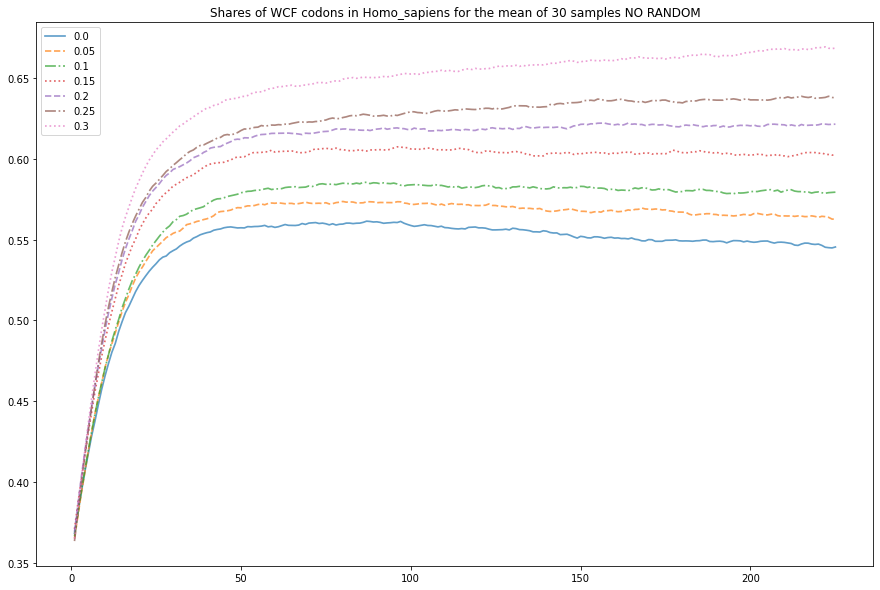

In [17]:
import matplotlib.pyplot as plt
result_folder = 'C:\Work\Lab\pr-29-trna-or-mutagenesis\local data\Simulation results(short list) No random'

lines = ['-', '--', '-.', ':', '--', '-.', ':']
for species in short_species_list[-1:]:
    plt.figure(figsize=(15, 10), facecolor='white')
    for i, coef in enumerate(coefficients_list):
        wcf_share = wcf_share_calculation(f'{result_folder}\\{coef}\{species}\FrequenciesMean.csv', mode='Total')
        plt.plot(wcf_share, alpha=0.7, label=coef, linewidth=1.7, ls=lines[i])
        # wcf_share = wcf_share_calculation(f'{result_folder}\\{coef}\Mus_musculus\FrequenciesMean.csv', mode='Total')
        # plt.plot(wcf_share, label=coef, alpha=0.5)
    # plt.xlim(-0.01, 50)
    plt.legend()
    plt.title(f'Fraction of WCF codons in {species} for the mean of 30 samples NO RANDOM')
    plt.show()

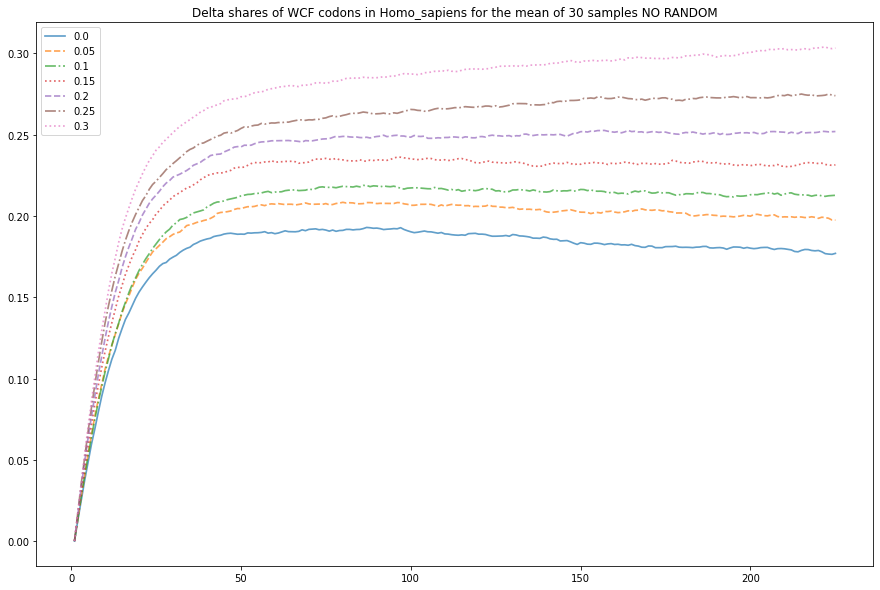

In [15]:
lines = ['-', '--', '-.', ':', '--', '-.', ':']
for species in short_species_list[-1:]:
    plt.figure(figsize=(15, 10), facecolor='white')
    for i, coef in enumerate(coefficients_list):
        wcf_share = wcf_share_calculation(f'{result_folder}\\{coef}\{species}\FrequenciesMean.csv', mode='Total')
        wcf_share -= wcf_share[1]
        plt.plot(wcf_share, alpha=0.7, label=coef, linewidth=1.7, ls=lines[i])
        # wcf_share = wcf_share_calculation(f'{result_folder}\\{coef}\Mus_musculus\FrequenciesMean.csv', mode='Total')
        # plt.plot(wcf_share, label=coef, alpha=0.5)
    # plt.xlim(-0.01, 50)
    plt.legend()
    plt.title(f'Delta fractions of WCF codons in {species} for the mean of 30 samples NO RANDOM')
    plt.show()

## None

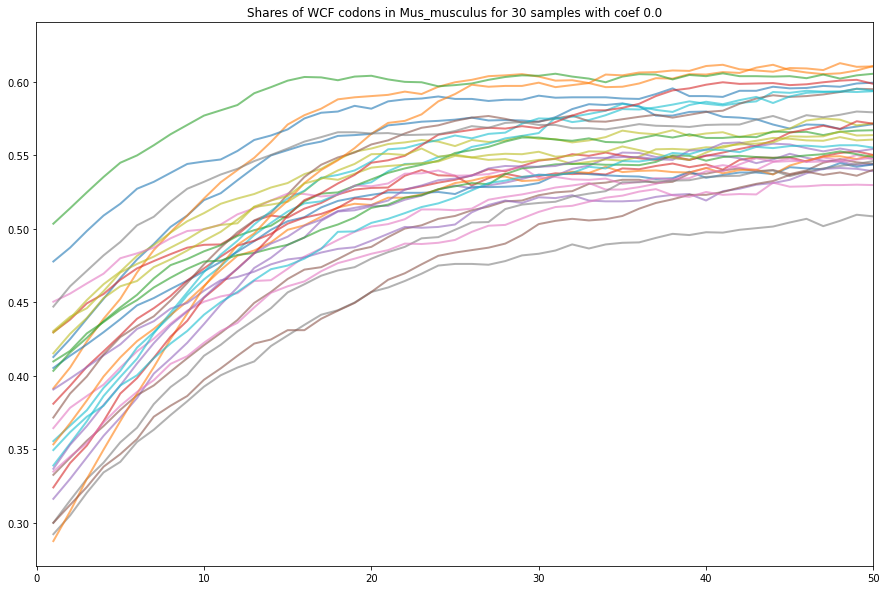

In [9]:
import matplotlib.pyplot as plt
result_folder = 'C:\Work\Lab\pr-29-trna-or-mutagenesis\local data\Simulation results(short list)'
for species in short_species_list[:1]:
    plt.figure(figsize=(15, 10), facecolor='white')
    for sample in range(30):
        for coef in [0.0]:
            wcf_share = wcf_share_calculation(f'{result_folder}\\{coef}\{species}\{sample}\Frequencies.csv', mode='Total')
            plt.plot(wcf_share, alpha=0.6, linewidth=2)
            # wcf_share = wcf_share_calculation(f'{result_folder}\\{coef}\Mus_musculus\FrequenciesMean.csv', mode='Total')
            # plt.plot(wcf_share, label=coef, alpha=0.5)
    plt.xlim(-0.01, 50)
    plt.title(f'Fraction of WCF codons in {species} for 30 samples with coef {coef}')
    plt.show()

## not None

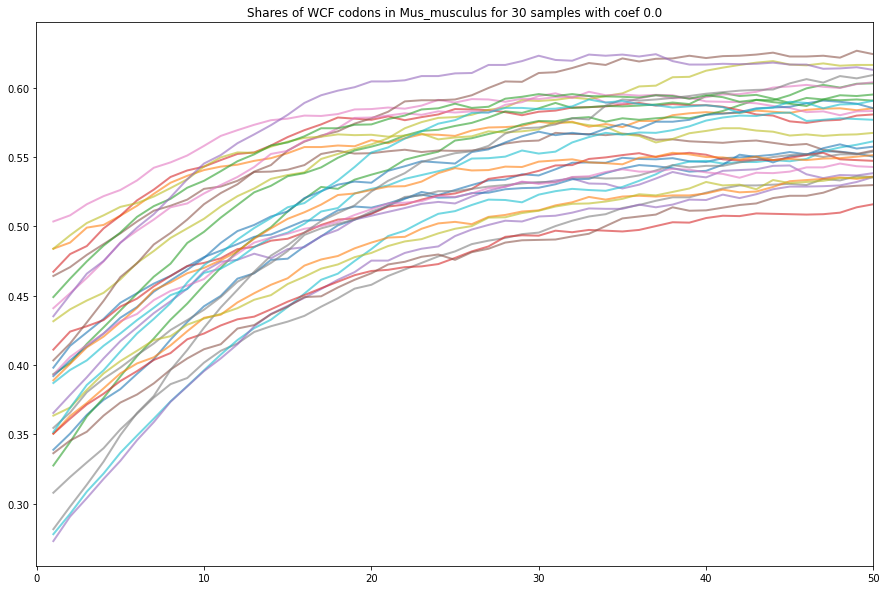

In [28]:
import matplotlib.pyplot as plt
result_folder = 'C:\Work\Lab\pr-29-trna-or-mutagenesis\local data\Simulation results(short list Leu1_2) not None'
for species in short_species_list[:1]:
    plt.figure(figsize=(15, 10), facecolor='white')
    for sample in range(30):
        for coef in [0.0]:
            wcf_share = wcf_share_calculation(f'{result_folder}\\{coef}\{species}\{sample}\Frequencies.csv', mode='Total')
            plt.plot(wcf_share, alpha=0.6, linewidth=2)
            # wcf_share = wcf_share_calculation(f'{result_folder}\\{coef}\Mus_musculus\FrequenciesMean.csv', mode='Total')
            # plt.plot(wcf_share, label=coef, alpha=0.5)
    plt.xlim(-0.01, 50)
    plt.title(f'Fraction of WCF codons in {species} for 30 samples with coef {coef}')
    plt.show()

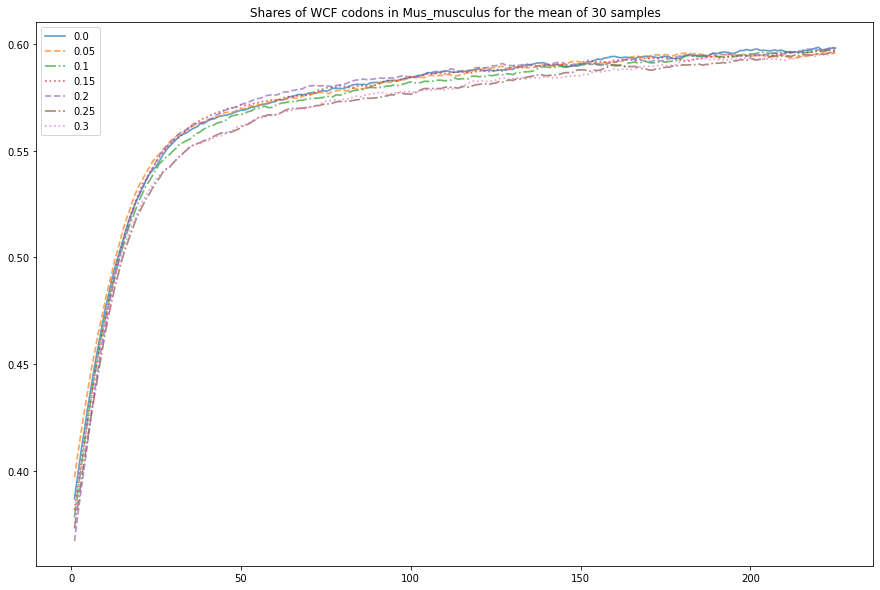

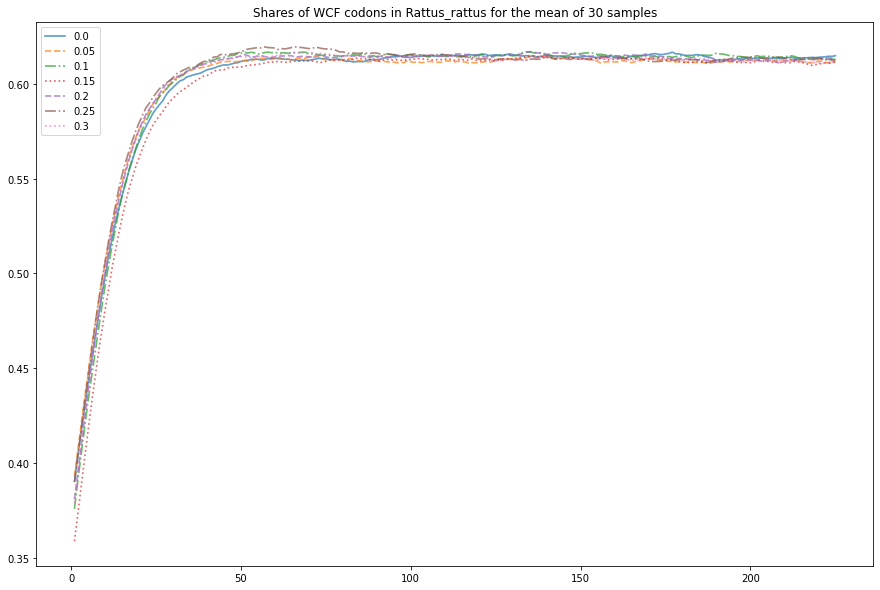

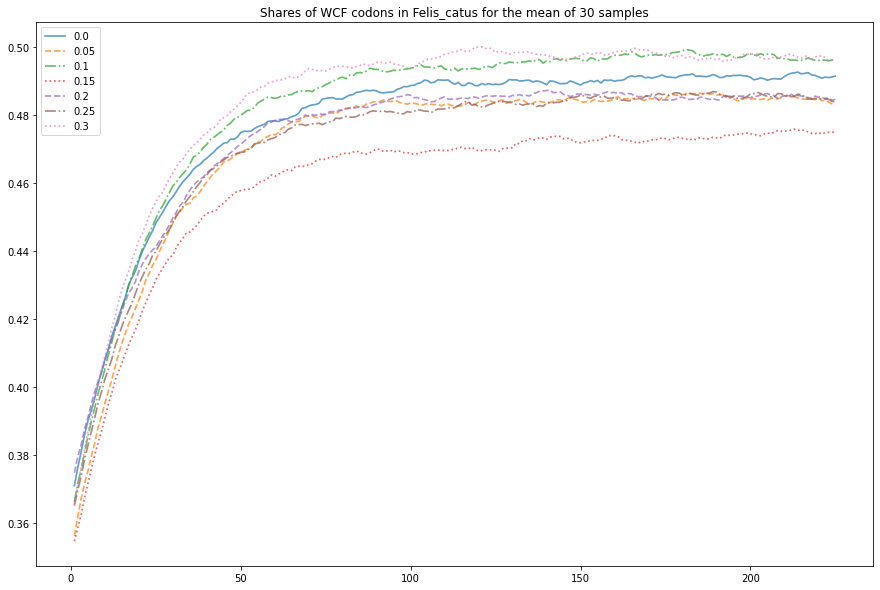

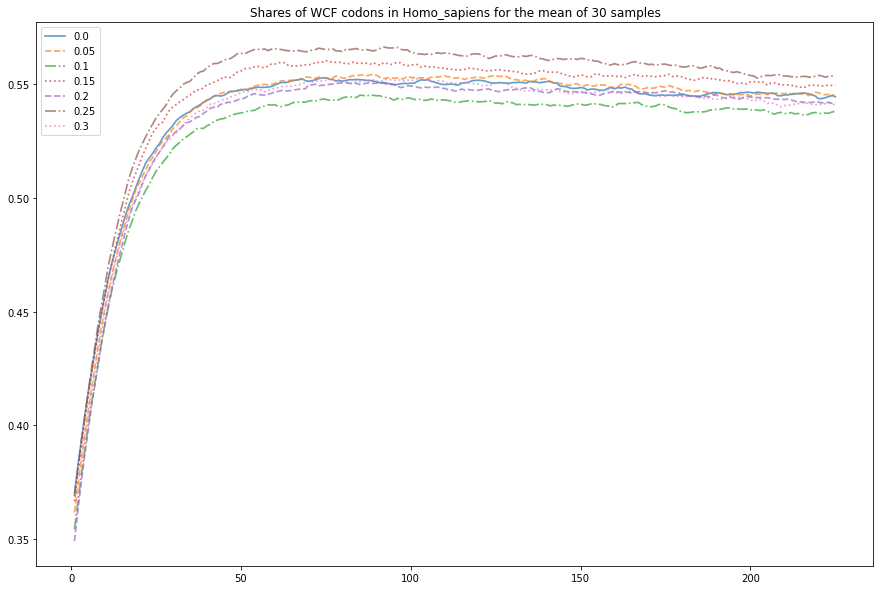

In [46]:
# WCF_share
lines = ['-', '--', '-.', ':', '--', '-.', ':']
for species in short_species_list:
    plt.figure(figsize=(15, 10), facecolor='white')
    for i, coef in enumerate(coefficients_list):
        wcf_share = wcf_share_calculation(f'{result_folder}\\{coef}\{species}\FrequenciesMean.csv', mode='Total')
        plt.plot(wcf_share, alpha=0.7, label=coef, linewidth=1.7, ls=lines[i])
        # wcf_share = wcf_share_calculation(f'{result_folder}\\{coef}\Mus_musculus\FrequenciesMean.csv', mode='Total')
        # plt.plot(wcf_share, label=coef, alpha=0.5)
    # plt.xlim(-0.01, 50)
    plt.legend()
    plt.title(f'Fraction of WCF codons in {species} for the mean of 30 samples')
    plt.show()

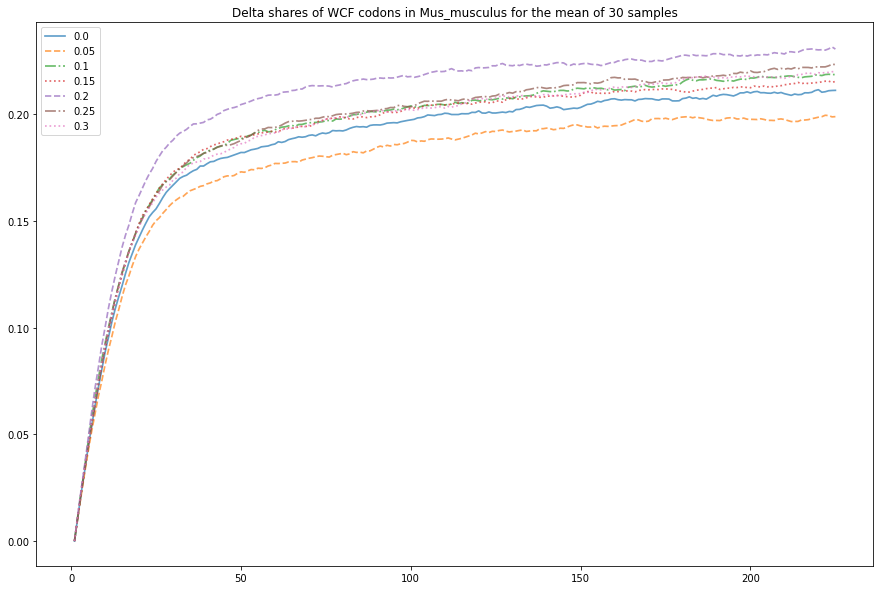

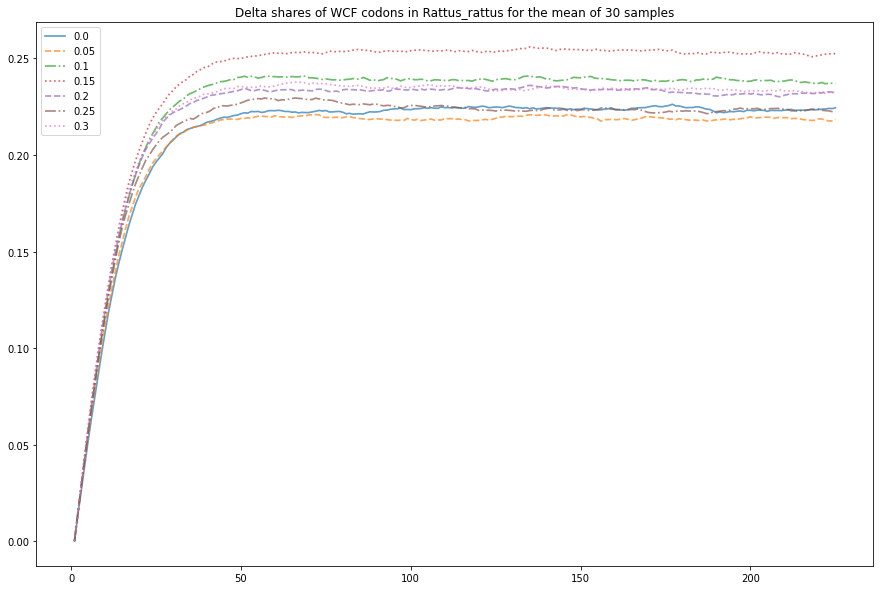

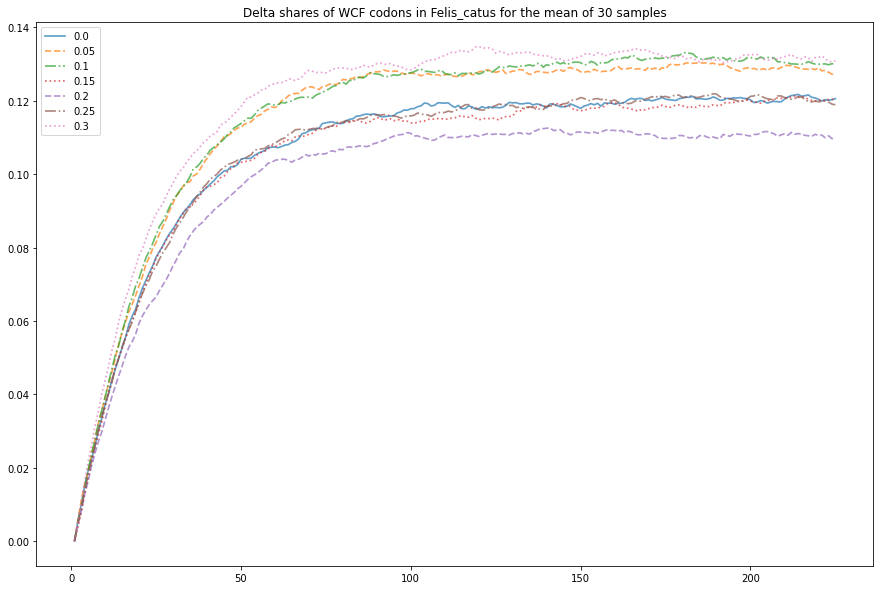

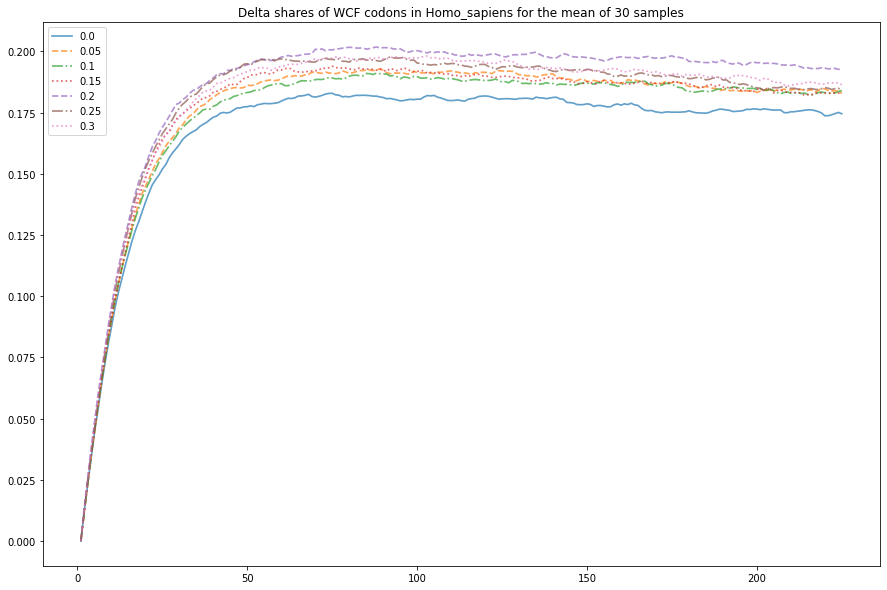

In [47]:
# delta WCF_share
lines = ['-', '--', '-.', ':', '--', '-.', ':']
for species in short_species_list:
    plt.figure(figsize=(15, 10), facecolor='white')
    for i, coef in enumerate(coefficients_list):
        wcf_share = wcf_share_calculation(f'{result_folder}\\{coef}\{species}\FrequenciesMean.csv', mode='Total')
        wcf_share -= wcf_share[1]
        plt.plot(wcf_share, alpha=0.7, label=coef, linewidth=1.7, ls=lines[i])
        # wcf_share = wcf_share_calculation(f'{result_folder}\\{coef}\Mus_musculus\FrequenciesMean.csv', mode='Total')
        # plt.plot(wcf_share, label=coef, alpha=0.5)
    # plt.xlim(-0.01, 50)
    plt.legend()
    plt.title(f'Delta fractions of WCF codons in {species} for the mean of 30 samples')
    plt.show()

## Per genes analysis

In [13]:
for coefficient in tqdm(coefficients_list):
    for species in short_species_list:
        codons_sum_all_genes = CU.loc[CU.Species==species, ALL_CODONS].iloc[0].sum()
        
        genes_sp = CU_genes[CU_genes.Species==species].Gene.unique()
        for gene in genes_sp:
            codon_usage_obs = CU_genes.loc[(CU_genes.Species==species) & (CU_genes.Gene==gene), ALL_CODONS].iloc[0]
            result_folder = f'C:\Work\Lab\pr-29-trna-or-mutagenesis\local data\Simulation results(per genes)\{coefficient}\{gene}\{species}'
            simulation(species=species, result_folder=result_folder, codon_usage_obs=codon_usage_obs, selection_multiplier=coefficient, samples_number=30, gene=gene)

  0%|          | 0/7 [00:00<?, ?it/s]

In [38]:
# CONTINUE
for coefficient in tqdm(coefficients_list[1:]):
    for species in short_species_list:
        codons_sum_all_genes = CU.loc[CU.Species==species, ALL_CODONS].iloc[0].sum()
        
        genes_sp = CU_genes[CU_genes.Species==species].Gene.unique()
        for gene in genes_sp:
            codon_usage_obs = CU_genes.loc[(CU_genes.Species==species) & (CU_genes.Gene==gene), ALL_CODONS].iloc[0]
            result_folder = f'C:\Work\Lab\pr-29-trna-or-mutagenesis\local data\Simulation results(per genes)\{coefficient}\{gene}\{species}'
            simulation_continue(species=species, result_folder=result_folder, codon_usage_obs=codon_usage_obs, selection_multiplier=coefficient, samples_number=30, gene=gene)

  0%|          | 0/6 [00:00<?, ?it/s]

# Dictionaries NOT string

In [107]:
TOTAL_MUTATIONS = 150*150       # ~22k достаточно для насыщения изменения кодонов
MUTATIONS_PER_GEN = 100
TOTAL_GENERATIONS = TOTAL_MUTATIONS // MUTATIONS_PER_GEN     # Количество поколений
                    
errouneous_sp_list = []

species_list = os.listdir('C:\Work\Lab\Practice\Results_AllGenes_shift')
species_list = sorted(list(set(species_list)-set(err_list)))
result_folder = 'C:\Work\Lab\pr-29-trna-or-mutagenesis\local data\Simulation results(dicts, no sel, no mut_id)'

for species in species_list[:1]: # Цикл по списку видов
    probability = 0

    
    mutations = ['A_T', 'A_G', 'A_C', 'T_A', 'T_G', 'T_C', 'G_A', 'G_T', 'G_C', 'C_A', 'C_T', 'C_G']    # Список однонуклеотидных замен
    mutspec = list(MUT_SPEC_DATA[MUT_SPEC_DATA.Species == species].iloc[0].values[1:])  # Вытаскивает мутспек для текущего вида
    # mutspec_stack = []

    # for i in range(len(mutspec)):   # Представляет мутспек в виде отрезка от 0 до 1, чтобы работала рулетка
    #     mutspec_stack.append(probability)
    #     probability += float(mutspec[i])


    for sample in tqdm(range(1)): # Количество генераций каждого вида(см. сколько папок уже есть в папке каждого вида)
        os.makedirs(f"{result_folder}/{species}/{sample}", exist_ok=True)  # Создает папку для результатов

        # Генератор генома на основе CodonUsage текущего вида
        DNA = {}
        cu_sp = CU[CU.Species==species].iloc[0]

        for aa in aa_dict:
            aa_codons = aa_dict[aa]
            number_aa = cu_sp[aa_codons].sum()
            codon_numbers = constrained_sum_sample_nonneg(len(aa_codons), number_aa)
            DNA |= {c:n for c, n in zip(aa_codons, codon_numbers)}

        CodonUsage_list = [[cu_sp[c] for c in ALL_CODONS]]     # Создаем датафреймы для подсчета CodonUsage и
        # Frequency_list = []
        observed_frequency = pd.read_csv(r'C:\Work\Lab\Practice\CodonFrequencyAllGenes.csv', sep='\t').copy()
        # Frequency_list.append(list(observed_frequency[observed_frequency.Species == species].values[0][1:]))
            # Записывает частоты кодонов из живого генома текущего вида
        codon_mut_choice_time = 0

        dna_keys = list(DNA.keys())
        dna_vals = list(DNA.values())
        
        for generation in range(TOTAL_GENERATIONS):
            
            errouneous_sp_counter = 0
            if generation % 1 == 0: # Регулирует раз в сколько поколений считать частоты кодонов
                CodonUsage_list.append([DNA[c] for c in ALL_CODONS])  # Add a list of codon usage for current gen to CodonUsage 
                # frequency_values = []  # Список значений частот кодонов
                # for e in range(64):
                #     frequency_values.append(CodonUsage_list[generation][e] / sum(DNA.values()))   # Расчитывает частоту каждого кодона
                # Frequency_list.append(frequency_values)  # Записывает в строку текущего поколения
                # Сохраняет значения
            
            # Мутагенез через список кодонов
            mut_counter = 0
            
      

            while mut_counter < MUTATIONS_PER_GEN:        # Цикл по всей ДНК # and generation < TOTAL_GENERATIONS-1
                codon_mut_choice_timer = time.time()

                codon = random.choices(dna_keys, weights=dna_vals, k=1)[0] # Choose random codon considering its number in all codon usage
                # mut_id = random.randint(0, 2)       # Выбираем нуклеотид из этого кодона
                mut_id = 2
                mutation = random.choices(mutations, weights=mutspec, k=1)[0]   # Choose a certain substitution considering its probability
                
                codon_mut_choice_time += time.time()-codon_mut_choice_timer

                if codon[mut_id] == mutation[0]:              # Check if choosen codon and substitution match
                    new_codon = MutableSeq(codon)                                   # выбранным нуклеотидом из кодона
                    codon = Seq(codon)
                    new_codon[mut_id] = mutation[2]           # Подставляем нуклеотид в кодоне
                    codon_aa = seq3(codon.translate(table=CODON_TABLE))
                    new_codon_aa = seq3(new_codon.translate(table=CODON_TABLE))
                    
                    if new_codon_aa != codon_aa:
                        continue
        
                    # codon_WCF = True if codon == ac_codon_dict[codon_aa] else False
                    # new_codon_WCF = True if new_codon == ac_codon_dict[new_codon_aa] else False
                    
                    success = random.random()   # 'success' treshold is needed for possibility of positive selection
                                                # it's impossible to make a substitution more frequent without it
                    selection_multiplier = 0
                    
                    if success < (0.8+0.8*selection_multiplier):
                        DNA[str(codon)] -=1
                        DNA[str(new_codon)] += 1 
                        mut_counter += 1
        print(codon_mut_choice_time)

        CodonUsage = pd.DataFrame(data=CodonUsage_list, columns=ALL_CODONS)
        Frequency = CodonUsage / sum(DNA.values())
        
        CodonUsage.to_csv(f'{result_folder}\{species}\{sample}\Codons.csv', sep='\t', index=False)
        Frequency.to_csv(f'{result_folder}\{species}\{sample}\Frequencies.csv', sep ='\t', index=False)
        

    # Расчет средних частот кодонов для ВСЕХ смодулированных образцов и корреляций
    samples_number = len(next(os.walk(f'{result_folder}\{species}'))[1])    # Количество смодулированных образцов

    # Средние частоты
    FrequenciesMean = pd.DataFrame(0, index=range(TOTAL_GENERATIONS+1), columns=ALL_CODONS)


    for sample in range(samples_number):
        freq = pd.read_csv(f'{result_folder}\{species}\{sample}\Frequencies.csv', sep='\t').copy()
        FrequenciesMean += freq
    FrequenciesMean /= samples_number
    
    FrequenciesMean.to_csv(f'{result_folder}\{species}\FrequenciesMean.csv', sep='\t', index=False)

    # Корреляции
    spearman = []
    pearson = []
    pv_s = []
    pv_p = []
    data1 = FrequenciesMean.loc[0]
    for i in FrequenciesMean.index[1:]:
        data2 = FrequenciesMean.loc[i]
        corrp, p_p = pearsonr(data1, data2)
        pearson.append(corrp)
        pv_p.append(p_p)
        corrs, p_s = spearmanr(data1, data2)
        spearman.append(corrs)
        pv_s.append(p_s)
    
    spear_corr = pd.DataFrame({'spearman':spearman, 'pearson':pearson, 'pv_s':pv_s, 'pv_p':pv_p})
    spear_corr.to_csv(f'{result_folder}\{species}\SpearmanMean.csv', sep='\t', index=False)

print(errouneous_sp_list)

  0%|          | 0/1 [00:00<?, ?it/s]

1.913494348526001
[]


In [ ]:
# Генератор генома на основе CodonUsage текущего вида
DNA = []


for aminoacid in AA.columns.values[:-1]:
    odds = [0]
    for i in range(len(aa_dict_seq3[aminoacid])):    # Создаем список вероятностей по вырождености аминокислоты
        odds.append(random.random() + odds[-1])
    for k in range(AA[AA.Species == species][aminoacid].values[0]):  # Цикл длиной кол-ву кодонов для аминокислоты
        odd = random.uniform(0, odds[-1])
        for q in range(len(aa_dict_seq3[aminoacid])):    # Для учета вырожденности АА
            if odd < odds[q+1] and odd > odds[q]:
                DNA.append(aa_dict_seq3[aminoacid][q])

In [168]:
species = 'Abbottina_rivularis'
DNA_str = {}
cu_sp = CU[CU.Species==species].iloc[0]

for aa in aa_dict:
    aa_codons = aa_dict[aa]
    number_aa = cu_sp[aa_codons].sum()
    codon_numbers = constrained_sum_sample_nonneg(len(aa_codons), number_aa)
    DNA_str |= {c:n for c, n in zip(aa_codons, codon_numbers)}


## Calculation of codon usage

In [123]:
CodonUsage_list = []

# Список однонуклеотидных замен
mutations = ['A_T', 'A_G', 'A_C', 'T_A', 'T_G', 'T_C', 'G_A', 'G_T', 'G_C', 'C_A', 'C_T', 'C_G']

for generation in range(TOTAL_GENERATIONS):
    errouneous_sp_counter = 0
    if generation % 1 == 0: # Регулирует раз в сколько поколений считать частоты кодонов
        codon_usage = Counter(DNA)      # Расчет CodonUsage
        CodonUsage_list.append([])
        if len(list(codon_usage)) < 64:                     # Проверка наличия всех 64 кодонов
            for t in ALL_CODONS:                              # без нее возникали ошибки
                if t not in list(codon_usage):              # если кодон исчезает приписываем ему ноль
                    codon_usage[t] = 0
        for codon in ALL_CODONS:     # Записывает CodonUsage
            CodonUsage_list[generation].append(codon_usage[codon])
        frequency_values = []  # Список значений частот кодонов
        for e in range(64):
            frequency_values.append(CodonUsage_list[generation][e] / len(DNA))   # Расчитывает частоту каждого кодона
        Frequency_list.append(frequency_values)  # Записывает в строку текущего поколения

{0: 'a', 1: 'a', 2: 'a', 3: 'a', 4: 'v', 5: 'v'}

In [129]:
for generation in range(TOTAL_GENERATIONS):
    errouneous_sp_counter = 0
    if generation % 1 == 0: # Регулирует раз в сколько поколений считать частоты кодонов
        CodonUsage_list.append([DNA_str[c] for c in ALL_CODONS])  # Add a list of codon usage for current gen to CodonUsage 
        frequency_values = []  # Список значений частот кодонов
        for e in range(64):
            frequency_values.append(CodonUsage_list[generation][e] / len(DNA))   # Расчитывает частоту каждого кодона
        Frequency_list.append(frequency_values)  # Записывает в строку текущего поколения

Counter({'a': 3, 'p': 3})

## Mutagenesis

In [ ]:
# Мутагенез через список кодонов
mut_counter = 0

while mut_counter < MUTATIONS_PER_GEN:        # Цикл по всей ДНК # and generation < TOTAL_GENERATIONS-1
    codon_id = random.randint(0, len(DNA)-1)
    codon = MutableSeq(DNA[codon_id])   # Выбираем отдельный кодон
    mut_id = random.randint(0, 2)       # Выбираем нуклеотид из этого кодона
    mut_probability = random.uniform(0, mutspec_stack[-1])  # Задаем значение рулетки
    counter = 0
    while mut_probability >= mutspec_stack[counter + 1]:    # Смотрим на какою именно замену она выпала
        counter += 1
    if codon[mut_id] == mutations[counter][0]:              # Сопоставляем нуклеотид замены из мутспека с
        
        new_codon = codon                                   # выбранным нуклеотидом из кодона
        codon = Seq(codon)
        new_codon[mut_id] = mutations[counter][2]           # Подставляем нуклеотид в кодоне
        codon_aa = seq3(codon.translate(table=CODON_TABLE))
        new_codon_aa = seq3(Seq(new_codon).translate(table=CODON_TABLE))
        
        if new_codon_aa != codon_aa:
            continue

        # codon_WCF = True if codon == ac_codon_dict[codon_aa] else False
        # new_codon_WCF = True if new_codon == ac_codon_dict[new_codon_aa] else False
        
        success = random.random()   # 'success' treshold is needed for possibility of positive selection
                                    # it's impossible to make a substitution more frequent without it
        selection_multiplier = 0
        
        if success < (0.8+0.8*selection_multiplier):
            DNA[codon_id] = str(new_codon)     # Проверка на синонимичность мутировавшего кодона
            mut_counter += 1


In [ ]:
# Мутагенез через список кодонов
mut_counter = 0

while mut_counter < MUTATIONS_PER_GEN:        # Цикл по всей ДНК # and generation < TOTAL_GENERATIONS-1
    codon = random.choices(list(DNA_str.keys()), weights=list(DNA_str.values()), k=1)[0] # Choose random codon considering its number in all codon usage
    mut_id = random.randint(0, 2)       # Выбираем нуклеотид из этого кодона
    mutation = random.choices(mutations, weights=mutspec, k=1)[0]   # Choose a certain substitution considering its probability
    
    if codon[mut_id] == mutation[0]:              # Check if choosen codon and substitution match
        new_codon = MutableSeq(codon)                                   # выбранным нуклеотидом из кодона
        codon = Seq(codon)
        new_codon[mut_id] = mutation[2]           # Подставляем нуклеотид в кодоне
        codon_aa = seq3(codon.translate(table=CODON_TABLE))
        new_codon_aa = seq3(Seq(new_codon).translate(table=CODON_TABLE))
        
        if new_codon_aa != codon_aa:
            continue

        # codon_WCF = True if codon == ac_codon_dict[codon_aa] else False
        # new_codon_WCF = True if new_codon == ac_codon_dict[new_codon_aa] else False
        
        success = random.random()   # 'success' treshold is needed for possibility of positive selection
                                    # it's impossible to make a substitution more frequent without it
        selection_multiplier = 0
        
        if success < (0.8+0.8*selection_multiplier):
            DNA[str(codon)] -=1
            DNA[str(new_codon)] += 1
            mut_counter += 1
    else: 
        continue

In [207]:
test = []
for i in range(1000000):
    test.append(random.choices(mutations, weights=mutspec, k=1)[0])
for i in range(len(mutspec)):
    print(mutspec[i]*1000000, Counter(test)[mutations[i]])

11369.349052242 11306
28349.523418001398 28283
13838.938422814701 13808
59071.672118970404 58750
7980.8529622716 7862
128591.17014869001 128670
473567.57076442003 473144
51220.9703810743 51694
79542.4227665674 79624
75204.59573014 75554
60217.96316072861 60332
11044.9710740803 10973


In [222]:
a = 'AAA'
b = MutableSeq(a)
a = Seq(a)
b[2] = 'T'
print(a,b)
DNA_str[str(a)]

AAA AAT


14

In [ ]:
mutations = ['A_T', 'A_G', 'A_C', 'T_A', 'T_G', 'T_C', 'G_A', 'G_T', 'G_C', 'C_A', 'C_T', 'C_G']    # Список однонуклеотидных замен
mutspec = list(MUT_SPEC_DATA[MUT_SPEC_DATA.Species == species].iloc[0].values[1:])
random.choices(mutations, weights=mutspec, k=1)[0]

# Summarize of codons

In [4]:
# Summarize of codons with excluding species that have non-zero values in stop codons   
CU = pd.read_csv(r'C:\Work\Lab\pr-29-trna-or-mutagenesis\raw\AllGenesCodonUsage.csv', sep='\t').copy()
cu_only_codons = CU[CU.Gene != 'ND6'].drop(columns=['Gene','NeutralA','NeutralT','NeutralG','NeutralC','Taxonomy','Class'])
cu_codons_sum = cu_only_codons.groupby('Species').sum()
cu_codons_sum[(cu_codons_sum[aa_dict['Xaa']] == 0).any(axis=1)]
# .to_csv(r'C:\Work\Lab\pr-29-trna-or-mutagenesis\raw\CodonUsage.csv', sep='\t')

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
Species,,,,,,,,,,,,,,,,,,,,,
Abalistes_stellaris,64,81,7,39,124,135,9,39,0,45,...,6,32,103,19,12,6,107,132,14,93
Abbottina_obtusirostris,60,64,15,59,142,92,16,45,0,43,...,7,41,81,16,34,7,104,122,15,97
Abbottina_rivularis,63,87,15,31,130,109,17,48,0,34,...,9,33,92,12,24,12,100,113,11,97
Ablennes_hians,76,80,3,46,131,114,2,58,0,37,...,3,44,101,15,10,8,138,115,10,113
Abramis_brama,69,69,7,46,131,98,16,50,0,45,...,8,42,106,12,9,11,111,121,11,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zosterops_lateralis,80,102,4,30,140,131,4,61,0,46,...,4,40,98,21,4,8,59,160,3,55
Zu_cristatus,43,51,33,64,72,74,15,96,0,30,...,9,70,87,19,25,7,131,103,32,132
diploid_Megalobrama_amblycephala_x_Xenocypris_davidi,71,74,7,46,145,103,11,44,0,41,...,7,29,105,15,10,8,81,152,5,64


In [48]:
CU = pd.read_csv(r'C:\Work\Lab\pr-29-trna-or-mutagenesis\raw\CodonUsage.csv', sep='\t').copy()
CU

,Species,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,Abalistes_stellaris,64,81,7,39,124,135,9,39,0,...,6,32,103,19,12,6,107,132,14,93
1,Abbottina_obtusirostris,60,64,15,59,142,92,16,45,0,...,7,41,81,16,34,7,104,122,15,97
2,Abbottina_rivularis,63,87,15,31,130,109,17,48,0,...,9,33,92,12,24,12,100,113,11,97
3,Ablennes_hians,76,80,3,46,131,114,2,58,0,...,3,44,101,15,10,8,138,115,10,113
4,Abramis_brama,69,69,7,46,131,98,16,50,0,...,8,42,106,12,9,11,111,121,11,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3849,Zosterops_lateralis,80,102,4,30,140,131,4,61,0,...,4,40,98,21,4,8,59,160,3,55
3850,Zu_cristatus,43,51,33,64,72,74,15,96,0,...,9,70,87,19,25,7,131,103,32,132
3851,diploid_Megalobrama_amblycephala_x_Xenocypris_...,71,74,7,46,145,103,11,44,0,...,7,29,105,15,10,8,81,152,5,64
3852,diploid_Xenocypris_davidi_x_Megalobrama_amblyc...,72,79,5,42,144,101,7,46,0,...,4,41,109,18,7,5,100,152,9,64


# Markov chain

In [ ]:
TOTAL_MUTATIONS = 150*150       # ~22k достаточно для насыщения изменения кодонов
MUTATIONS_PER_GEN = 100
TOTAL_GENERATIONS = TOTAL_MUTATIONS // MUTATIONS_PER_GEN     # Количество поколений
                    
errouneous_sp_list = []

species_list = os.listdir('C:\Work\Lab\Practice\Results_AllGenes_shift')
species_list = sorted(list(set(species_list)-set(err_list)))
result_folder = 'C:\Work\Lab\pr-29-trna-or-mutagenesis\local data\Simulation results(Markov chain)'

for species in species_list[:1]: # Цикл по списку видов
    probability = 0

    
    mutations = ['A_T', 'A_G', 'A_C', 'T_A', 'T_G', 'T_C', 'G_A', 'G_T', 'G_C', 'C_A', 'C_T', 'C_G']    # Список однонуклеотидных замен
    mutspec = list(MUT_SPEC_DATA[MUT_SPEC_DATA.Species == species].iloc[0].values[1:])  # Вытаскивает мутспек для текущего вида

A_C    0.005126
A_G    0.024882
A_T    0.009729
C_A    0.019392
C_G     0.00048
C_T    0.099236
G_A    0.621942
G_C    0.020183
G_T    0.019591
T_A    0.024871
T_C    0.150563
T_G    0.004005
Name: 601, dtype: object


In [66]:
ms_series = MUT_SPEC_DATA[MUT_SPEC_DATA.Species == species].iloc[0][1:].sort_index()
# ms_series.values = np.array([i/sum(ms_series) for i in ms_series])
P = []
for n1 in ['A', 'C', 'G', 'T']:
    matrix_row = []
    for n2 in ['A', 'C', 'G', 'T']:
        if n1 == n2:
            matrix_row.append(0.0)
        else:    
            matrix_row.append(ms_series[f'{n1}_{n2}'])
    matrix_row = [i/sum(matrix_row) for i in matrix_row]
    P.append(matrix_row)
P = np.array(P)
print(P)


[[0.         0.25839253 0.52932566 0.21228181]
 [0.51345575 0.         0.07540901 0.41113524]
 [0.78362288 0.13162063 0.         0.08475649]
 [0.30193496 0.65727224 0.04079279 0.        ]]


In [62]:
P.sum()

4.0

In [86]:
state = np.array([[100, 100, 100, 100]])
state
print(state)

[[100 100 100 100]]


In [89]:
for i in range(10):
    state = np.dot(state, P)
print(state.sum())

354.0
351.0
349.0
347.0
346.0
344.0
343.0
341.0
338.0
336.0


In [101]:
P = []
for codon1 in ALL_CODONS:
    matrix_row = []
    for codon2 in ALL_CODONS:
        if codon1 == codon2:
            matrix_row.append(0.0)
        elif codon1[0] != codon2[0] or codon1[1] != codon2[1]:
            matrix_row.append(0.0)
        else:    
            matrix_row.append(ms_series[f'{codon1[2]}_{codon2[2]}'])
    matrix_row = [i/sum(matrix_row) for i in matrix_row]
    P.append(matrix_row)
P = np.array(P)
print(P[0])

[0.         0.25839253 0.52932566 0.21228181 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [103]:
pd.DataFrame(P, columns=ALL_CODONS, index=ALL_CODONS)

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
AAA,0.000000,0.258393,0.529326,0.212282,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
AAC,0.513456,0.000000,0.075409,0.411135,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
AAG,0.783623,0.131621,0.000000,0.084756,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
AAT,0.301935,0.657272,0.040793,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
ACA,0.000000,0.000000,0.000000,0.000000,0.0,0.258393,0.529326,0.212282,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGT,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.301935,0.657272,0.040793,0.0,0.000000,0.000000,0.000000,0.000000
TTA,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.258393,0.529326,0.212282
TTC,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.513456,0.000000,0.075409,0.411135
TTG,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.783623,0.131621,0.000000,0.084756


In [125]:
state = [c/sum(CodonUsage_list[0]) for c in CodonUsage_list[0]]
for i in range(1000):
    state = np.dot(state, P)
print(state)

[0.01893269 0.01326187 0.01144757 0.01044175 0.02936499 0.02056944
 0.01775542 0.01619536 0.00482977 0.00338313 0.0029203  0.00266371
 0.04414409 0.03092182 0.02669153 0.02434632 0.01999524 0.01400616
 0.01209004 0.01102776 0.02057481 0.01441214 0.01244047 0.01134741
 0.00685827 0.00480405 0.00414682 0.00378247 0.04626918 0.03241039
 0.02797647 0.02551835 0.01622802 0.01136732 0.00981221 0.00895007
 0.03052414 0.02138139 0.01845629 0.01683465 0.02154077 0.01508876
 0.01302453 0.01188015 0.01941567 0.01360019 0.0117396  0.01070812
 0.00994932 0.00696925 0.00601582 0.00548724 0.01690419 0.01184096
 0.01022105 0.00932299 0.01352335 0.00947277 0.00817684 0.00745839
 0.03100712 0.0217197  0.01874832 0.01710102]
